# ** Quantum Approximate Optimization Algorithm**

This notebook is part of a project . This project was sponsored by ... .

<div align="center">
  <img src="logo_sponsor1.png" alt="Sponsor 1" width="150"/>
  <img src="logo_sponsor2.png" alt="Sponsor 2" width="150"/>
  <img src="logo_sponsor3.png" alt="Sponsor 3" width="150"/>
</div>

This program simulates QAOA on Max-Cut problem using qiskit. \

### Prerequisites & Required Knowledge

Before diving into this notebook, make sure you're familiar with:
- **All Gates, especially Identity, Pauli-Z and Pauli-X**

> **Difficulty Level**: Intermediate
> **Estimated Time**: 4 hours

## 1. Explanation & Theory
QAOA is a hybrid quantum-classical algorithm used primarily for solving combinatorial optimization problems. These include well-known problems like the Travelling Salesman Problem, the Knapsack Problem, or any other optimization problems where the difficulty grows exponentially.



### 1.1 Concrete Example - The Problem We're Solving

Let's start with a practical example that illustrates why we need QAOA:

**Scenario**:

I am using QAOA to solve the Max-Cut problem. Although Max-Cut is simple to understand, it is an NP-complete problem, meaning that solutions for larger inputs are extremely hard to find. The problem is defined as follows: you have a graph with n vertices, some of which are connected by edges. The goal is to divide the vertices into two groups such that the number of edges between the groups is maximized. In other words, we want the cut that cuts the most edges.

![Max-Cut Example](https://quantum.cloud.ibm.com/assets-docs-learning/_next/image?url=%2Fdocs%2Fimages%2Ftutorials%2Fquantum-approximate-optimization-algorithm%2Fmaxcut-illustration.avif&w=3840&q=75)

Max-Cut might sound abstract, but it has many real-world applications. It can be used in microchip design and manufacturing, in social sciences and statistics (for classifying groups of people), in finance, and more. It is also commonly used as a benchmark problem in quantum computing because it is simple to describe yet difficult to solve.

**Classical Approach**: brute force algorithms O($2^n$)

### 1.2 How the algorithm works (overview)?

Firstly, you have to translate the problem into a quantum operator called the cost Hamiltonian. It evaluates better solutions and penalizes worse ones. Then, we apply the mixer Hamiltonian, which mixes the solutions to avoid getting stuck in a local minimum. We can repeat this process multiple times, with each iteration making the more probable (and hopefully best) solutions even more probable. This is the quantum part.

The cost and mixer Hamiltonians rotate the qubits by some amount (β, γ), but at the start, we don't know these parameters. We need to optimize them to obtain the best results. This is done in a classical way by running the circuit repeatedly with different parameters to see which combination performs better.

Once we find the best-performing parameters, we run the circuit one more time with them to obtain the results.

The results are not necessarily optimal, but are usually good enough. QAOA can pick up some combinations that mimic the perfect solution, but it performs worse than the optimal solution. Therefore, it is important to check several of the top solutions, which is again done by a classical algorithm.
### 1.3 Mathematical Foundation

We can transcribe the problem as follows:

$$

\max \sum_{(i,j) \in E} \left( x_i + x_j - 2 x_i x_j \right)

$$
Where $x_i$ means, that vertex i is in group x. ($x \in \{0,1\}$). The expression in sum is pretty clever. If the $x_i$ and $x_j$ are different, it is equal to 1, else it is equal to zero.

$x_i = 0, x_j = 0 : 0 + 0 - 2 \cdot 0 \cdot 0 = 0$

$x_i = 1, x_j = 0 : 1 + 0 - 2 \cdot 1 \cdot 0 = 1$

$x_i = 0, x_j = 1 : 0 + 1 - 2 \cdot 0 \cdot 1 = 1$

$x_i = 1, x_j = 1 : 1 + 1 - 2 \cdot 1 \cdot 1 = 0$

We transcribe this as (because conventions)
$$\min \sum_{(i,j) \in E} \left( 2 x_i x_j - x_i - x_j \right)$$

Then we need to express it in QUBO notation:
$$\min_{x \in \{0,1\}^n} \; x^T Q x$$

In this notation, x is a vector expressing the solution, $ x^T$ is transposed vector of solution and Q is a matrix representing the connections between edges. For triangle it looks like this:
let's say we want to try solution of $x=(1,1,0)$. 
$$
x^T Q x = 
\begin{pmatrix} 1 & 1 & 0 \end{pmatrix}
Q
\begin{pmatrix} 1 \\ 1 \\ 0 \end{pmatrix}

$$

We have to choose carefully matrix Q, in this case it can be 
$$
\begin{pmatrix}
2 & -1 & -1 \\
-1 & 2 & -1 \\
-1 & -1 & 2
\end{pmatrix}
$$
The value $x_{ii}$ is how many edges connect to given vertex i, and $x_{ij}$ is minus one if there exists an edge between i and j.

$$
x^T Q x = 
\begin{pmatrix} 1 & 1 & 0 \end{pmatrix}
\cdot
\begin{pmatrix}
2 & -1 & -1 \\
-1 & 2 & -1 \\
-1 & -1 & 2
\end{pmatrix}
\cdot
\begin{pmatrix} 1 \\ 1 \\ 0 \end{pmatrix}
$$
or we can also write it like this
$$
x^T Q x \;=\; \sum_{i,j} Q_{ij} \, x_i x_j
$$

When we do the math, we get exactly the same results as using the formula before, it is just another formulation.

Now we need to transform this into Hamiltonian. Hamiltonian is an operator, that acts on the quantum state and usually represents its lowest energy level. This is represented by its eigenvalues.
We can substitute the x by z:
$z_i = 1 - 2x_i$ 
($x_i = \frac{1-z_i}{2}$)
to change the values from {0,1} to {-1,1}.
then we can rewrite the original expression as before.
$\frac{1}{4} \sum_{i,j} Q_{ij} \, (1 - z_i)(1 - z_j)$

We can further rewrite it like:
$$
\frac{1}{4} \sum_{i,j} Q_{ij} z_i z_j 
\;-\; \frac{1}{4} \sum_{i,j} Q_{ij} z_i
\;-\; \frac{1}{4} \sum_{i,j} Q_{ij} z_j
\;+\; \frac{1}{4} \sum_{i,j} Q_{ij}
$$

Now we just merge the two middle terms and omit the last one, because its constant and it does not matter in optimization.
$$\frac{1}{4} \sum_{i,j} Q_{ij} z_i z_j 
 \;-\; \frac{1}{4} \sum_{i,j} (Q_{ij} + Q_{ji}) z_i
$$

Now we need to translate this problem to quantum one, and it shows up, that only thing we need is substitute the z by Pauli-Z gate:
$$Z_i = 
\begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}$$
so:
$$
H_C \;=\; \sum_{i,j} Q_{ij} Z_i Z_j \;+\; \sum_{i} b_i Z_i$$
(b is substituent for $\sum_{i,j} (Q_{ij} + Q_{ji})$) we can't just multiply n qubits by this matrix, so what we mean by using this is using following:
$$
I \otimes Z \otimes ... \otimes Z ... \otimes I
$$
where the I is identity gate, Z is Pauli-Z gate and they are on ith and jth positions.

How does it works?
Each qubit represents one vertex. Its value is its group. When the qubit is zero, its eigenvalue after multiplying it by Z is one. When it is one, its eigenvalue is minus one. If two qubits are in the same group, we get (-1)*(-1) or 1*1, both equaling 1. If they are different, we get (-1)*1 = -1.

In Max-cut problem, we try to minimize the value, so b is always zero. Matrix Q represents the weight of edges, that we do not use there, so we can ommit it as well. We end up with following expression for cost Hamiltonian:
$$
H_C = \sum_{i,j} Z_i Z_j 
      $$
and we got the worst part - cost Hamiltonian.

Now we need to have good mixer hamiltonian ($H_X$). It can be just as simple as apllying X rotation on each qubit.

### 1.4 Translation to algorithm
The next challenge is to find the parameters, how much the Hamiltonians should act. This is represented by  $\beta$ for the mixer Hamiltonian and $\gamma$ for the cost Hamiltonian. We have to choose these parameters carefully, because it can very much affect the result. With wrong parameters, we end up with completely wrong results. Finding the parameters is done by a classical optimization algorithm.

As I mentioned earlier, the code is a combination of classical and quantum. We run a classical algorithm minimize that runs the quantum algorithm with different parameters. It tries different $\beta, \gamma$ until it finds a local minimum. We run this multiple times to avoid local minima and find truly the best parameters. It evaluates how good certain parameters are based on checking the most probable result, whose score is calculated by a brute-force classical algorithm.

After a certain time, it uses the best-found parameters to run the quantum circuit again and get results. It then tries to find the best result by checking the most probable results by brute force.

## 2. The Code

In first block of code, I am importing some libraries the code needs. Then we set the graph - edges is list of edges in graph, [x, y] means there exists an edge from vertex x to vertex y. Default shape is a square - you can then change it

Depth means how many layers the circuit has (how many times the cost and mixer Hamiltonians repeats) - more layers = probable results become even more probable. 

Shots is number of shots used in the simulation. While optimizing the parametrs, it uses only 1/10 of the shots. 

Variable Seeds sets how many times it tries to find best parameters - to avoid local minima. 

Checkin is how many best solutions we check by brute force to find the real best solution.

In [1939]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
import random

edges= [
#(0,1), (1,2),(2,3),(3,0)#optimal solution = 4
(0,1), (0,2),(0,3), (1,4), (2,5), (3,6), (4,5), (5,6) #optimal solution = 7
#(0, 7), (1, 2), (1, 3), (1, 4), (1, 7), (2, 4), (2, 5), (2, 7), (2, 8), (2, 9), (2, 10), (4, 6), (5, 6), (5, 7), (5, 8), (5, 9), (7, 9), (7, 10) #optimal solution = 14
#(0, 2),(0, 4),(0, 6),(0, 11),(1, 3),(1, 7),(1, 10),(1, 13),(2, 12),(2, 13),(2, 14),(3, 10),(3, 11),(3, 12),(4, 8),(4, 11),(5, 9),(5, 13),(6, 12),(7, 8),(7, 12),(7, 13),(9, 10),(9, 11),(13, 14) #optimal solution = idk
#uncomment row to try different graph
]
#edges is list of edges in graph, [x, y] means there is an edge from vertex x to vertex y
n = num_vertices = len({v for e in edges for v in e})
#n is number of vertices
depth = 5 #how many layers
shots = 10000 #how many times it simulates
seeds = 100 #how many times tries to optimize ɣ, β
checkin = 10 #this number of most prbable results is being checked


There I define my functions - to function max_cut_value you input the graph (list of edges) and bitstring representing some solution, and it returns score of this solution. To function exp_val you input number of occurrences of solution (and graph and bitstring) and it returns score multiplied by number of occurrences.

In [1940]:
def exp_val(edges, string, count):
    score = max_cut_value(edges, string)
    val = (count * score)
    return val
"""
Input edges, concrete bitsring and number of occurences in given example and returns value times number of occurenses
"""
def max_cut_value(edges, bitstring):
    """
Counts up number of edges being cut in this bitstring
    """
    if isinstance(bitstring, str):
        bits = [int(b) for b in bitstring]
    else:
        bits = bitstring
    
    cut_value = 0
    for i, j in edges:
        if bits[i] != bits[j]:
            cut_value += 1
    return cut_value


There you can see the graph we are talking about

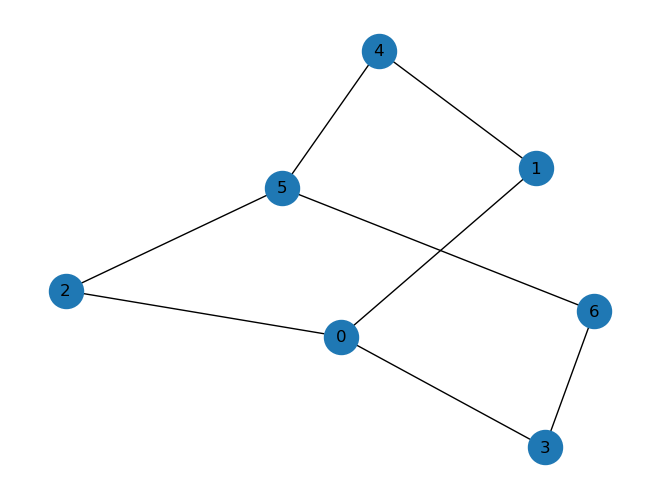

In [1941]:
graph = rx.PyGraph()
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
graph.add_edges_from([(i, j, 1) for (i, j) in edges])
draw_graph(graph, node_size=600, with_labels=True) #visualizing the graph


There we use function minimize. You input some other function and repeatedly runs it with different parameters, until the parameters are performing best as it can. You also input starting parameters. In this case, these are random and the minimize function is run multiple times to avoid local minima. In the end, it returns the best parameters it was able to find.

Finding the optimal parameters is hard. 

![Max-Cut Example](..\Media\parameters_graph.png)

There you can see the graph of depence of the cut value on beta, gamma. In the graph, there are values of gamma, beta ranging from -1 to 1. On the Z axis is averege value of the function (cuts in given graph) for given parameters. This graph is an example (values in square graph). As you can see, it has many different local maxima (for better visualization, there we are finding maxima instead of minima), so it is very important to run the optimalization multiple times.


In [1942]:
def f(params):#define the function
    gamma,beta = params
    q = QuantumRegister(n, 'q') #create n qubits
    c = ClassicalRegister(n, 'c') #create n classical bits
    qc = QuantumCircuit(q, c) #create the circuit
    for i in range (n):
        qc.h(q[i]) #apply Hadamard gate to every qubit
    for i in range(depth):
        for (i, j) in edges:
            qc.rzz(gamma, q[i], q[j]) #apply RZZ to every pair of qubits given in list of edges (turns around Z-axis by gamma) (cost Hadamard)
        for i in range (n):
            qc.rx(beta, q[i]) #apply RX (rotation around X-axis by beta) to every qubit (mixer Hadamard)
    for i in range (n):
        qc.measure(q[i], c[i]) #measure all qubits
#create the circuit
    simulator = AerSimulator(shots=shots/10) #setup the simulator for 1/10 shots times
    job = simulator.run(qc)
    #runs the simulator
    result = job.result()
    counts = result.get_counts()
    sorted_counts = sorted(counts.items(), key=lambda item: item[1], reverse=True)[0:checkin] #sort the results by probability
    exval = 0
    for j in (sorted_counts): #counts the expected value of top checkin counts
        count = j[1]
        bitstring = j[0]
        exval += exp_val(edges, bitstring, count)
    exval = exval / (shots/10)
    return -exval
#gets the value of this result

result = []
for i in range(seeds):
    result.append(minimize(f, [random.random(), random.random()], method='COBYLA')) #this function tries to optimilize it multiple times
best = min(result, key=lambda r: r["fun"]) #select best parameters
print("Best parameterssss are " + str(best["x"]))


Best parameterssss are [ 0.73933549 -0.65886511]


Now it comes to our main circuit. This is the same circuit as in the optimization of parameters, but there we run it with more shots to get more accurate results.

We start with n qubits (n = number of edges). We apply Hadamard gate to all of them. Then we apply Z-rotation to every pair of qubits connected by an edge. This will prefer the qubits to be in different groups, thus maximizing the number of cuts. Then we apply the X-rotation to mix the solution and the Z-rotations to take place. We can repeat this multiple times, with each repetition, the probable results become even more probable. In the end, we measure the circuit. 

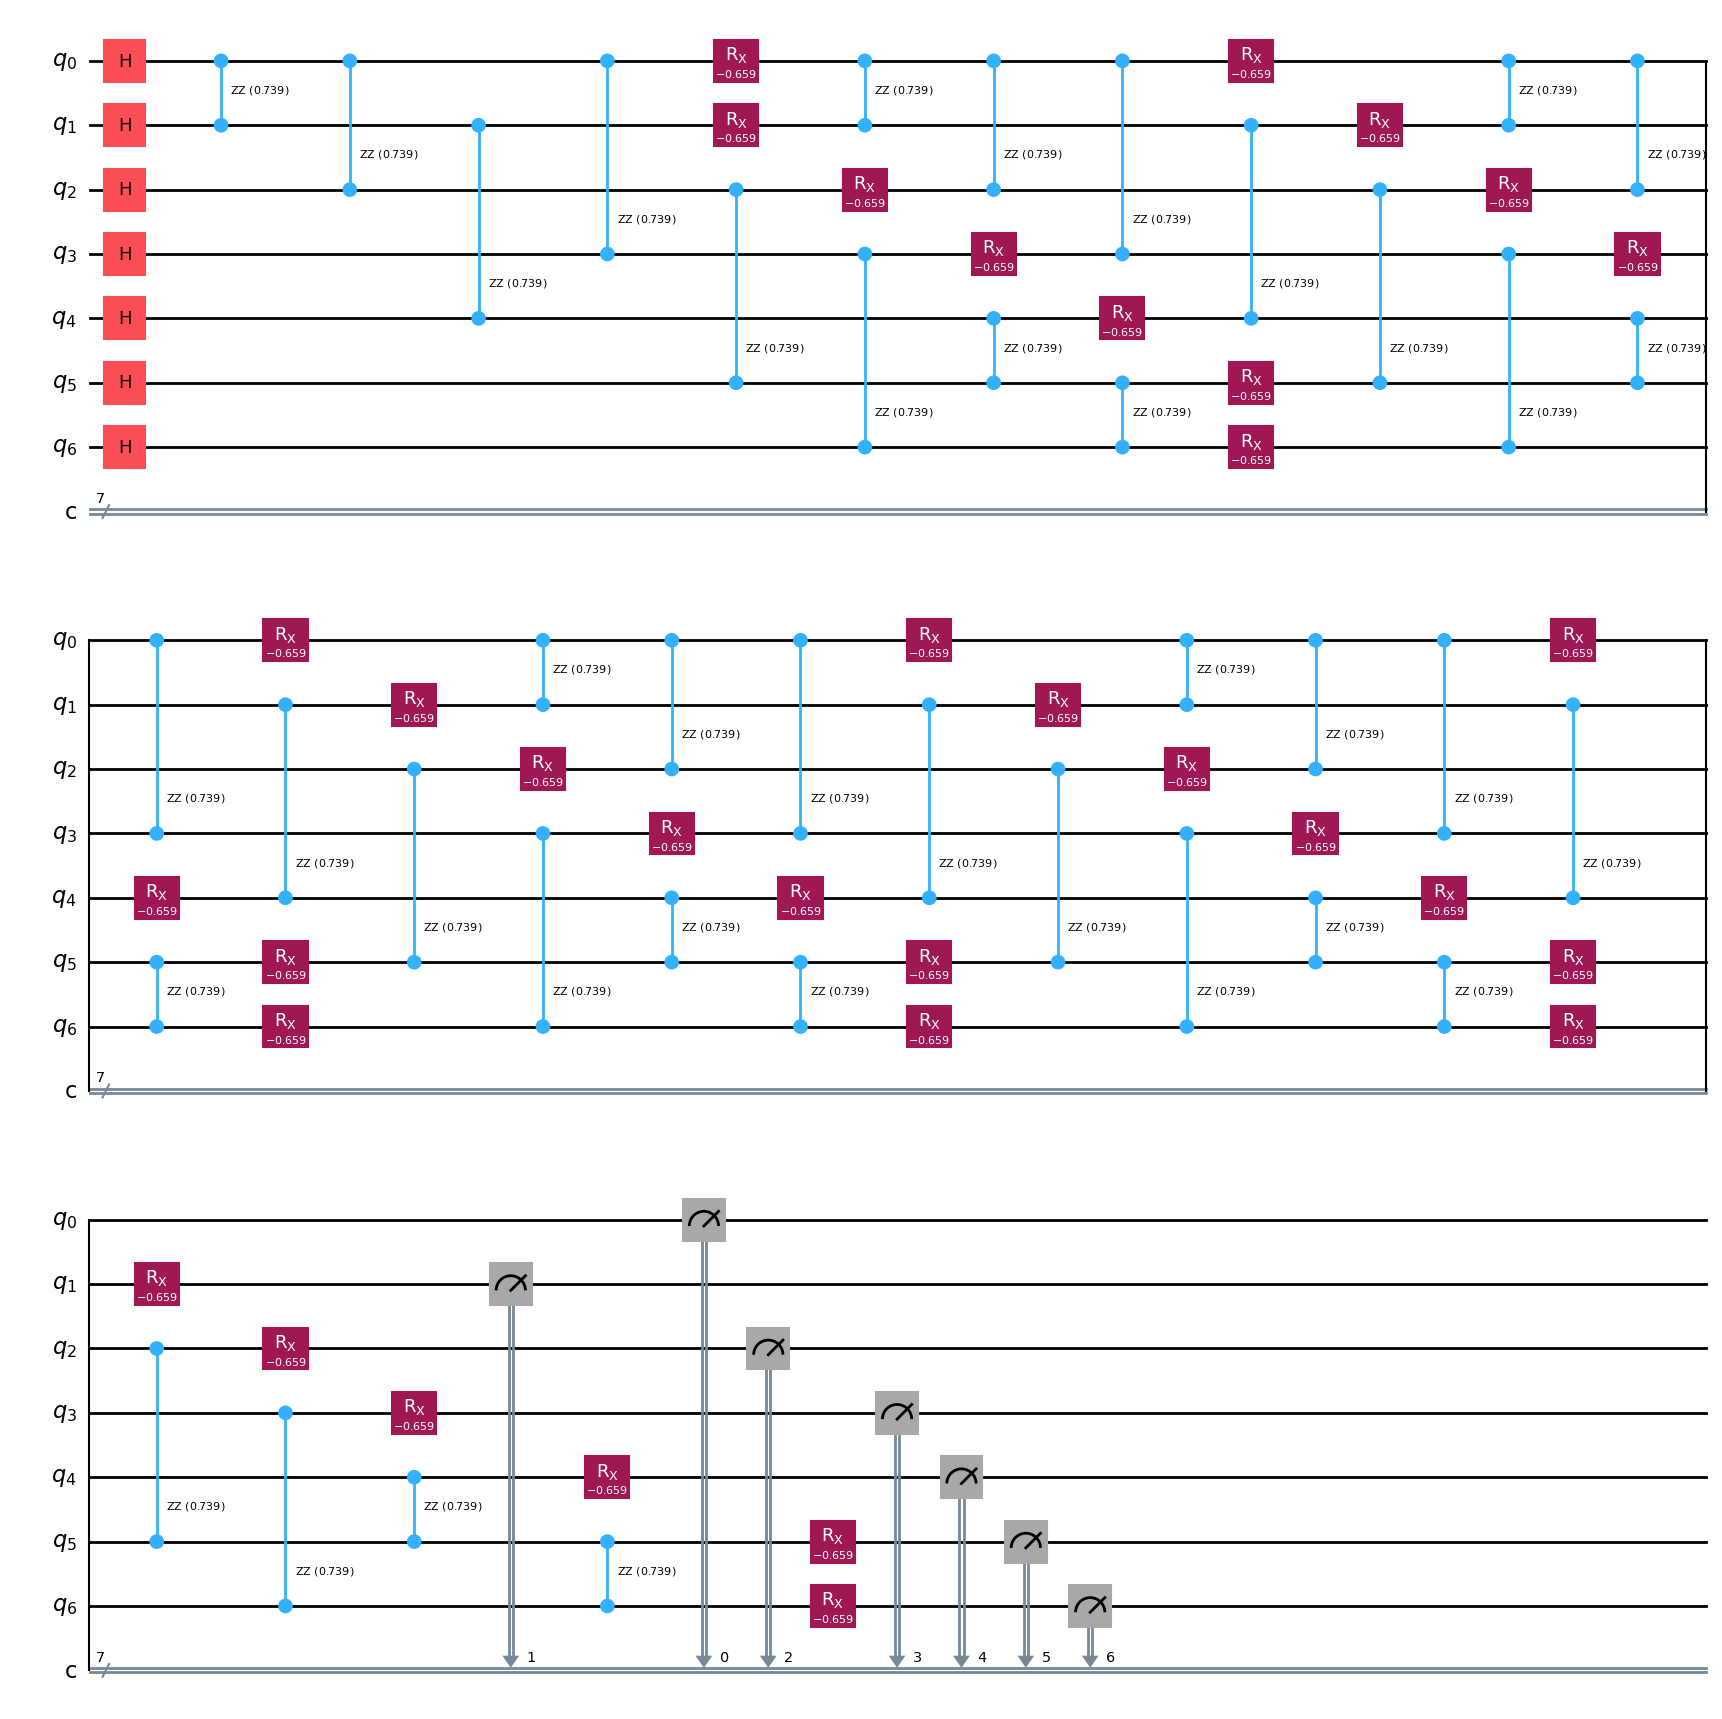

In [1943]:
q = QuantumRegister(n, 'q') #create n qubits
c = ClassicalRegister(n, 'c') #create n classical bits
qc = QuantumCircuit(q, c) #create the circuit
for i in range (n):
    qc.h(q[i]) #apply Hadamard gate to every qubit
for i in range(depth):
    gamma, beta = best["x"]
    for (i, j) in edges:
        qc.rzz(gamma, q[i], q[j]) #apply RZZ to every pair of qubits given in list of edges (turns around Z-axis by gamma) (cost Hadamard)
    for i in range (n):
        qc.rx(beta, q[i]) #apply RX (rotation around X-axis by beta) to every qubit (mixer Hadamard)
for i in range (n):
    qc.measure(q[i], c[i]) #measure all qubits
qc.draw("mpl")#draws the circuit

In [1944]:
simulator = AerSimulator(shots=shots) #runs the simulator shots times
job = simulator.run(qc)
result = job.result()
counts = result.get_counts()

Now we print the most probable solutions + we check some of the most probable solutions (by brute force) to find the truly best solution.

Most probable cut is 7 edges
Second probable cut is 5 edges
Third probable cut is 5 edges
Best cut found (in top 10) is 7 edges. (Probability: 15.01%)
Best found bitstring: 0101010


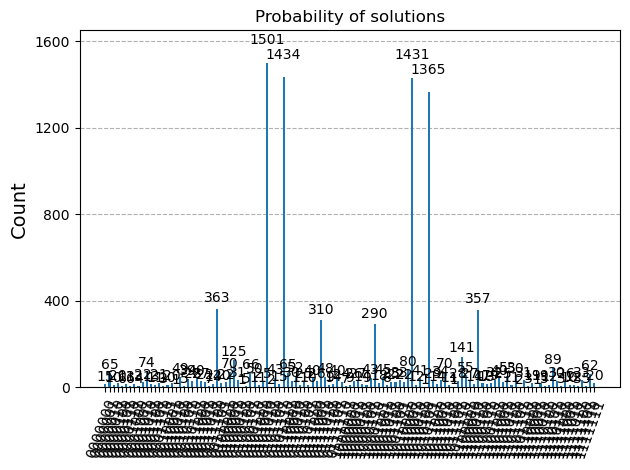

In [1945]:
sorted_counts = sorted(counts.items(), key=lambda item: item[1], reverse=True)[0:checkin] #sort the counts by probability
best_count = min(sorted_counts, key=lambda r: -max_cut_value(edges, r[0]))
print("Most probable cut is " + str(max_cut_value(edges, sorted_counts[0][0])) + " edges")
print("Second probable cut is " + str(max_cut_value(edges, sorted_counts[1][0])) + " edges")
print("Third probable cut is " + str(max_cut_value(edges, sorted_counts[2][0])) + " edges")
print("Best cut found (in top "+ str(checkin) +") is " + str(max_cut_value(edges, best_count[0])) + " edges. (Probability: " + str(100*best_count[1]/shots) + "%)")#find the best solution in top checkin results
print("Best found bitstring: " + best_count[0])
plot_histogram(counts, title="Probability of solutions")



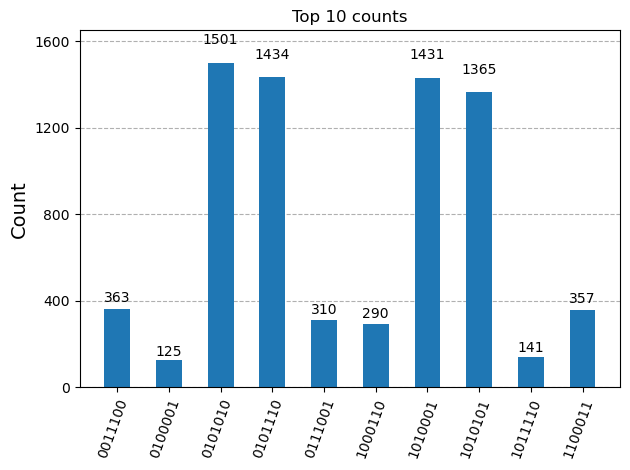

In [1946]:
counts_dict = dict(sorted_counts)
plot_histogram(counts_dict, title="Top " + str(checkin) + " counts")

There you can see the graph with the best found solution.

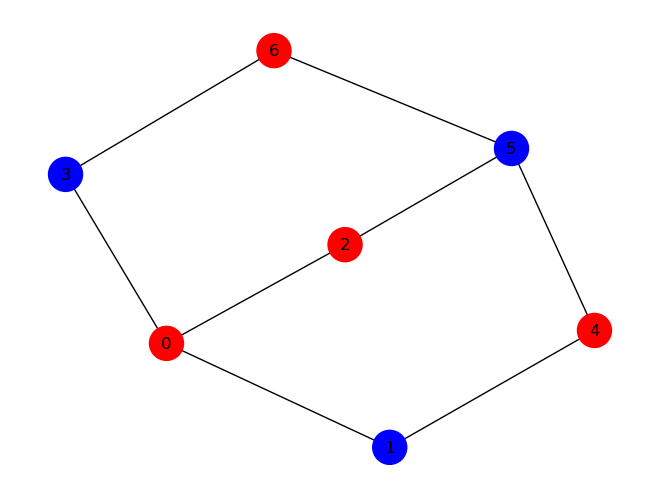

In [1947]:
graph = rx.PyGraph()
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
graph.add_edges_from([(i, j, 1) for (i, j) in edges])
group1 = []
group2 = []
max = best_count[0]
for i in range(len(max)):
    if max[i] == "0":
        group1.append(i)
    else:
        group2.append(i)

node_colors = ['red' if node in group1 else 'blue' for node in range(n)]

# draws the colored graph
draw_graph(graph, node_size=600, with_labels=True, node_color=node_colors)

## 3. Summary

In this notebook, we explored QAOA and applied it to the Max-Cut problem. We saw how to formulate the problem using QUBO and then translate it into Hamiltonians suitable for a quantum circuit.

We discussed the structure of the QAOA circuit, alternating cost and mixer Hamiltonians, and how the parameters 𝛾 and 𝛽 are optimized classically to improve the probability of measuring good solutions.

Finally, we ran the algorithm on a simple example graph, observed how the circuit evolves, and measured the results to find the best cut. This demonstrates how quantum and classical computation can work together to solve combinatorial optimization problems.

**Key Takeaway**: Sometimes you just won't find the best. Just good enough.

### 3.1 Follow-Up Notebooks

Ready to dive deeper? Continue your quantum computing journey with these related notebooks:

- **[Grover's algorithm]** → [Grover](./Circuits/Grover.ipynb)


### 3.2 Citations
- IBM. Quantum approximate optimization algorithm. Online. IBM Quantum Platform. 2016. Dostupné z: https://quantum.cloud.ibm.com/docs/en/tutorials/quantum-approximate-optimization-algorithm. [cit. 2025-08-20].
Wikipedia contributors. (2025, August 6). Hamiltonian (quantum mechanics). In Wikipedia, The Free Encyclopedia. Retrieved 07:37, August 20, 2025, from https://en.wikipedia.org/w/index.php?title=Hamiltonian_(quantum_mechanics)&oldid=1304495576
Wikipedia contributors. (2025, August 6). Maximum cut. In Wikipedia, The Free Encyclopedia. Retrieved 07:38, August 20, 2025, from https://en.wikipedia.org/w/index.php?title=Maximum_cut&oldid=1304549389
Farhi, E., Goldstone, J., & Gutmann, S. (2014). A Quantum Approximate Optimization Algorithm. arXiv:1411.4028. https://arxiv.org/abs/1411.4028
### 3.2 Get Involved

#### **Found an Issue?**
- Report bugs or suggest improvements: [GitHub Issues](https://github.com/mforgo/Quantum-Examples/issues)
- Contribute to the codebase: [Contributing guidelines link](https://github.com/mforgo/Quantum-Examples/blob/master/README.md)

#### **Contact & Feedback**
...

> *Author: Šimon Mařík | Last Updated: 20.8.2025 | Version: 1 | License: [License Type]*
